In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf

from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.layers import Input, Embedding, Concatenate
from tensorflow.keras.models import Model

import numpy as np
# from tensorflow_model_optimization.python.core.keras.compat import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import random
tf.random.set_seed(3407)
np.random.seed(3407)
random.seed(3407)

from create_spectrogram import (
    create_spectrogram_patches_from_audio_dataset, 
)
from helper_functions import (
    get_file_size, 
    convert_bytes, 
    convert_prefetchdataset_to_numpy_arrays,
    predict_and_print_full_results,
    evaluate_time_of_prediction
    )

2024-07-14 23:16:27.994634: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-14 23:16:28.032820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 23:16:28.032846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 23:16:28.033660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 23:16:28.038810: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-14 23:16:28.039899: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
sample_rate = 16000

In [5]:
train_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/training", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)
test_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/testing", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)
val_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/validation", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)

label_names = np.array(train_dataset.class_names)
print("Classes: ", label_names)

Found 11292 files belonging to 2 classes.


2024-07-14 23:16:32.623697: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-14 23:16:32.624126: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-07-14 23:16:32.706852: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-07-14 23:16:32.714456: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


Found 1393 files belonging to 2 classes.
Found 1380 files belonging to 2 classes.
Classes:  ['non_target' 'target']


In [8]:
train_spectrogram_ds = create_spectrogram_patches_from_audio_dataset(train_dataset, sample_rate = sample_rate).cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = create_spectrogram_patches_from_audio_dataset(test_dataset, sample_rate = sample_rate).cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = create_spectrogram_patches_from_audio_dataset(val_dataset, sample_rate = sample_rate).cache().prefetch(tf.data.AUTOTUNE)

# x_train_np, y_train_np = convert_prefetchdataset_to_numpy_arrays(train_spectrogram_ds)
# x_val_np, y_val_np = convert_prefetchdataset_to_numpy_arrays(val_spectrogram_ds)
# x_test_np, y_test_np = convert_prefetchdataset_to_numpy_arrays(test_spectrogram_ds)

In [9]:
for i in train_spectrogram_ds:
    print(i[0])
    break

UnimplementedError: {{function_node __wrapped__MakeIterator_device_/job:localhost/replica:0/task:0/device:CPU:0}} Only support ksizes across space.
	 [[{{node ExtractImagePatches}}]] [Op:MakeIterator] name: 

In [83]:
x_train_np, y_train_np = convert_prefetchdataset_to_numpy_arrays(train_spectrogram_ds, data_type='patches')
# x_val_np, y_val_np = convert_prefetchdataset_to_numpy_arrays(val_spectrogram_ds)
# x_test_np, y_test_np = convert_prefetchdataset_to_numpy_arrays(test_spectrogram_ds)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 352 has size 3

tf.Tensor([0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0], shape=(32,), dtype=int32)
0
tf.Tensor([0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
0
tf.Tensor([1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0], shape=(32,), dtype=int32)
1


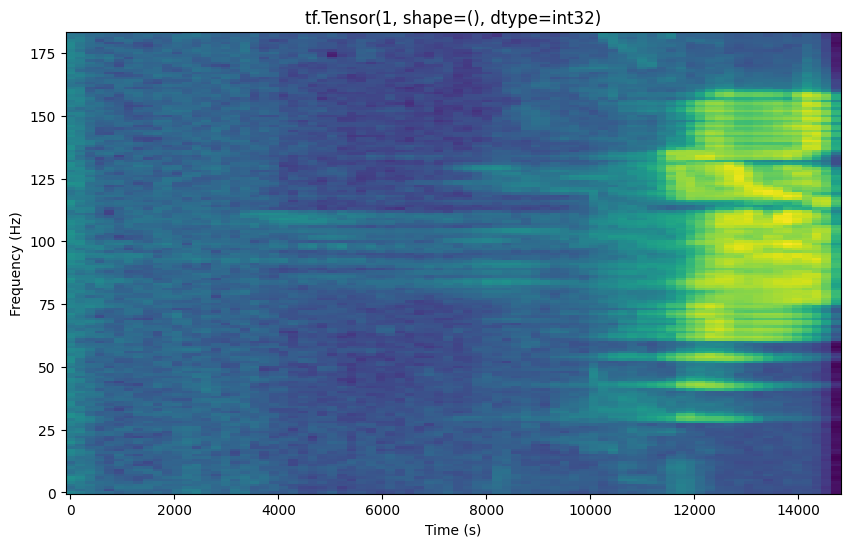

In [30]:
# non-target = 0, target = 1
# Print spectrograms of target or non-target class from dataset
class_number = 1

for i in train_spectrogram_ds:
    print(i[1])
    print(i[1][0].numpy())
    if i[1][0].numpy() == class_number:
        spectrogram = i[0][0]
        height = spectrogram.shape[0]
        width = spectrogram.shape[1]
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(X, Y, spectrogram)
        plt.title(i[1][0])
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
        break

In [4]:
from patchify import patchify

ModuleNotFoundError: No module named 'patchify'

In [ ]:
def transform_to_patches(image):
    patch_shape = (config["patch_size"], config["patch_size"], config["num_channels"])
    patches = patchify(image, patch_shape, config["patch_size"])

    # patches = np.reshape(patches, (64, 25, 25, 3))
    # for i in range(64):
    #     cv2.imwrite(f"files/{i}.png", patches[i])

    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    """ Label """
    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

In [27]:
print(tf.__version__)

2.15.0


In [31]:
y_train_np[0]

0

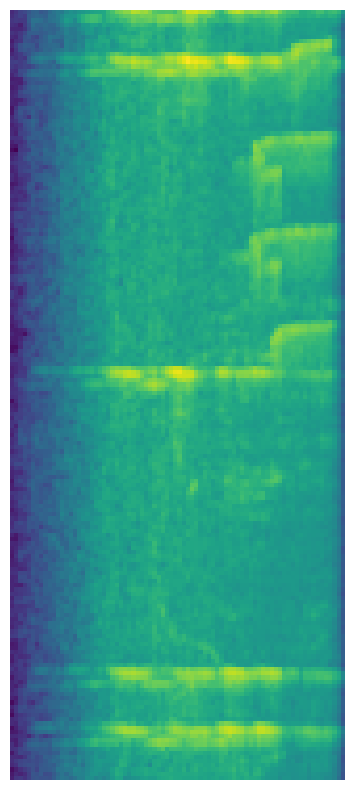

In [30]:
image = x_train_np[0]

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

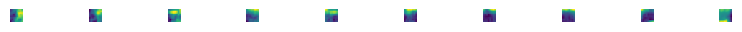

In [34]:
def extract_patches(image, patch_height, patch_width):
    patches = []
    img_height, img_width, _ = image.shape
    for y in range(0, img_height, patch_height):
        for x in range(0, img_width, patch_width):
            patch = image[y:y+patch_height, x:x+patch_width]
            patches.append(patch)
    return patches

patches = extract_patches(image, 8, 8)

# Display some patches
num_patches_to_display = 10
plt.figure(figsize=(10, 10))
for i in range(num_patches_to_display):
    plt.subplot(50, num_patches_to_display, i + 1)
    plt.imshow(patches[i])
    plt.axis('off')
plt.show()

In [35]:
def transform_to_patches(image):
    patch_shape = (config["patch_size"], config["patch_size"], config["num_channels"])
    patches = extract_patches(image, 8, 8)
    # patches = tf.keras.ops.reshape(
    #     patches, (
    #             32,
    #             num_patches_h * num_patches_w,
    #             self.patch_size * self.patch_size * channels,
    #         ),
    # )
    return patches

    # # patches = np.reshape(patches, (64, 25, 25, 3))
    # # for i in range(64):
    # #     cv2.imwrite(f"files/{i}.png", patches[i])

    # patches = np.reshape(patches, hp["flat_patches_shape"])
    # patches = patches.astype(np.float32)

    # """ Label """
    # class_name = path.split("/")[-2]
    # class_idx = hp["class_names"].index(class_name)
    # class_idx = np.array(class_idx, dtype=np.int32)

In [22]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(shape=input_shape) ## (None, 18, 900)

    """ Patch + Position Embeddings """
    patch_embed = Dense(cf["hidden_dim"])(inputs)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (18,)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (18, 32)
    embed = patch_embed + pos_embed ## (None, 18, 32)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (None, 19, 32)
    print(x.shape)

    """ Transformer Encoder """
    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    """ Classification Head """
    x = LayerNormalization()(x) ## (None, 19, 32)
    x = x[:, 0, :] ## (None, 32)
    x = Dropout(0.1)(x)
    x = Dense(2, activation="softmax")(x)

    model = Model(inputs, x)
    return model



(None, 231, 32)


In [29]:
config = {}
config["num_layers"] = 1
config["num_patches"] = 230
config["patch_size"] = 8
config["num_channels"] = 1

config["hidden_dim"] = 32
config["mlp_dim"] = 64
config["num_heads"] = 1
config["dropout_rate"] = 0.001


model = ViT(config)
model.summary()

(None, 231, 32)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 230, 64)]            0         []                            
                                                                                                  
 dense_16 (Dense)            (None, 230, 32)              2080      ['input_5[0][0]']             
                                                                                                  
 tf.__operators__.add_4 (TF  (None, 230, 32)              0         ['dense_16[0][0]']            
 OpLambda)                                                                                        
                                                                                                  
 class_token_4 (ClassToken)  (None, 1, 32)                32        ['tf.__o

In [24]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# EPOCHS = 1
# EPOCHS = 15
# history = model.fit(
#     train_spectrogram_ds,
#     epochs=EPOCHS
# )

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping

In [28]:
for i in train_spectrogram_ds:
    print(i[0].shape)

(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 184, 80)
(32, 1

In [26]:
# callbacks = [
#         ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
#         ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
#         CSVLogger(csv_path),
#         EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
#     ]

EPOCHS = 1
# EPOCHS = 15
model.fit(
    train_spectrogram_ds,
    epochs=EPOCHS,
    # callbacks=callbacks
)

ValueError: in user code:

    File "/home/polina/newname/venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/polina/newname/venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/polina/newname/venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/polina/newname/venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/polina/newname/venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/polina/newname/venv/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 230, 64), found shape=(None, None, 80)
